<a href="https://colab.research.google.com/github/ThaoPham96/DeepARV/blob/main/DeepARV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DeepARV: Ensemble Deep Learning to Predict Drug-Drug Interaction (DDI) of Clinical Relevance with Antiretrovial Therapy (ARV)**

In this study, we built an esemble learning algorithm to predict DDIs of clinical relevance between ARVs and comedications.

DDI severity grading between 29,142 drug pairs was extracted from the Liverpool HIV Drug Interaction database, https://www.hiv-druginteractions.org/. Molecular structure of each drug was converted to Morgan fingerprints where each atom was represented in a numerical format and compared by constructing drug similarity profiles. We developed DeepARV, a feed-forward neural network where drug similarity profiles were fed into the input layer and outputted 4 categories of DDI as 'traffic light' system:

*   Red: drugs should not be co-administered
*   Amber: interaction of potential clinical relevance manageable by monitoring/dose adjustment
*   Yellow: interaction of weak relevance
*   Green: no expected interaction

The imbalance in the distribution of DDI severity grades was addressed by undersampling and applying ensemble learning during training of DeepARV.

# Imports and installations

In [ ]:
!pip install tensorboard
!pip install tensorflow_addons

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.callbacks import Callback
import tensorflow.experimental.numpy as tnp
import math
import timeit
import datetime, os
import pandas as pd
from numpy import argmax
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm
from deep_arv_utils import *
from matplotlib.colors import LinearSegmentedColormap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# DeepARV

In [ ]:
class DeepARV_ensemble:
  ''' Training of DeepARV '''
  def __init__(self, train_df=None, test_df=None, n_models=5):

    # Load data
    self.train_df = train_df
    self.test_df = test_df
    self.n_models = n_models


  def build_model(self, feature):
    ''' Builds a single model '''
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(feature,))),
    model.add(Dropout(0.2)),
    model.add(Dense(512, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(256, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(128, activation='relu')),
    model.add(Dropout(0.2)),
    model.add(Dense(4, activation='softmax'))
    tf.keras.optimizers.Adam(learning_rate=0.001,
                            beta_1=0.9, beta_2=0.999,
                            epsilon=1e-07,
                            amsgrad=False,
                            name='Adam')
    model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    self.model = model
    return model

  #Undersample the majority
  def undersample(self ):
      minority = self.train_df[self.train_df.Label != 0]
      majority = self.train_df[self.train_df.Label == 0].sample(frac=1, random_state=42).reset_index(drop=True)

      # Split majority class for undersampling
      majority_dict = split_majority(majority,5,3000)
      train_split_dict = {} #dict to hold final training df
      n_model = 5
      self.undersampled_feature_dict = {}
      self.undersampled_label_dict = {}
      print('\n########################################\n')
      print('---------------------------------------')
      print('DDI 4-fold training distribution BEFORE undersampling : ', count_uniques_ddi(self.train_df))
      print('---------------------------------------')

      for i in range(5):
          train_split_dict[i] = pd.concat([majority_dict[i],minority]
                                          ).sample(frac=1,random_state=42
                                          ).reset_index(drop=True)
          print('---------------------------------------')
          print('DDI distribution for training model '+str(i)+ ' AFTER undersampling: \n', count_uniques_ddi(train_split_dict[i]))
          self.undersampled_feature_dict[i] = train_split_dict[i].drop(columns='Label')
          self.undersampled_label_dict[i] = train_split_dict[i].Label.dropna()
      return

  def train(self, n_models=5):
        print('\n########################################\n')
        print('Building models, balancing with class weights and training ...\n')
        self.model_dict = {}
        for i in range(n_models):
            print('Training model: ', i)
            class_weights = class_weight.compute_class_weight(
                                                      class_weight='balanced',
                                                      classes = np.unique(self.undersampled_label_dict[i]),
                                                      y = self.undersampled_label_dict[i])
            class_weights_model = dict(zip(np.unique(self.undersampled_label_dict[i]), class_weights))
            self.model_dict[i] = self.build_model(1374)
            self.model_dict[i].fit(self.undersampled_feature_dict[i],self.undersampled_label_dict[i],epochs=30,
                              validation_split=0.1,
                              batch_size = 128, class_weight=class_weights_model)


  def test(self):
      # Predict for all models
      print('\nPredicting for test set for each model, aggregating for final vote...\n')
      all_results = {}
      temp_results = {}
      for i in range(5):
          class_probability = self.model_dict[i].predict(self.test_df.iloc[:,:-1])
          class_prediction = [np.argmax(i) for i in class_probability]
          temp_results[i] = class_prediction
      # Vote max
      df_vote = pd.DataFrame(data=temp_results)
      df_vote['final_vote'] = df_vote.mode(axis=1)[0].astype(int)
      self.df_vote = df_vote

      self.macro_results, self.each_class_results = calculate_macro_metrics(self.df_vote , self.test_df)
      self.all_results_df = pd.DataFrame(self.each_class_results ,index=['Green','Yellow','Amber','Red','Macro'],
                      columns =['Accuracy','Precision','Sensitivity',
                                'Specificity','F1_score', 'Balanced Accuracy'])
  def save_models(self):
    for i in range(self.n_models):
      print('Saving models...')
      self.model_dict[i].save('DeepARV_model'+ str(i)+'.keras')

  def visualize_confusion_matrix(self):
    print('\n ------------------------------')
    print('Plotting confusion matrix ...')
    y_pred = self.df_vote.final_vote
    y_test = self.test_df['Label']
    plot_norm_confusion_matrix(y_pred, y_test)
    plot_confusion_matrix(y_pred, y_test)

  def load_pretrained_models(self):
    self.model_dict = {}

    print('\nLoading pretrained models...\n')
    for i in tqdm(range(self.n_models)):
      self.model_dict[i] = tf.keras.models.load_model('/content/drive/MyDrive/liverpool_hiv/Trained_Models/DeepARV_v1/DeepARV_model' +str(i))
    print('\n')






# Training - 5 fold cross validation

In [ ]:
def DeepARV_5_fold_cross_validation():

  # Load training data into dictionary with 5 folds
  train_5fold = load_training_data()

  #Store accuracy, precision,  sensitivity, specificity, f1_score, BAcc for each
  # class and macro.
  cv5_macro_results = np.zeros((5,6))
  cv5_each_class_results = []

  # Storage for each ensemble
  ensemble_dict = {}

  # iterate through each fold as test, remaining as training
  for f in range(5):
    print('\n########################################')
    print('\nRunning fold: ', f)
    folds = [i for i in range(5)]
    test_idx = folds.pop(f)
    test_ds = train_5fold[test_idx]
    train_ds = pd.concat([train_5fold[folds[0]], train_5fold[folds[1]],
                  train_5fold[folds[2]], train_5fold[folds[3]]])

    # Build ensemble, undersample to balance data, train and test.
    deepARV_ensemble = DeepARV_ensemble(train_ds, test_ds)
    deepARV_ensemble.undersample()
    deepARV_ensemble.train()
    deepARV_ensemble.test()
    deepARV_ensemble.save_models()
    ensemble_dict[f] = deepARV_ensemble.model_dict
    cv5_macro_results[f] = deepARV_ensemble.macro_results
    cv5_each_class_results.append(deepARV_ensemble.each_class_results)

  # Format and print macro results for each ensemble.
  result_df = print_final_result(cv5_each_class_results)


  return result_df, ensemble_dict



result_df, ensemble_dict =  DeepARV_5_fold_cross_validation()
print('\n ----  Results for each ensemble ---- \n ')
result_df

Loading data...
Distribution of DDI class in training set
  Clinical_label Numeric_label Amount
0          Green             0  16745
1         Yellow             1   1782
2          Amber             2   3728
3            Red             3   1063

########################################

Spliting data into 5 stratified folds...
--------------------------
  Clinical_label Numeric_label Amount
0          Green             0   3349
1         Yellow             1    357
2          Amber             2    746
3            Red             3    213
--------------------------
  Clinical_label Numeric_label Amount
0          Green             0   3349
1         Yellow             1    357
2          Amber             2    746
3            Red             3    213
--------------------------
  Clinical_label Numeric_label Amount
0          Green             0   3349
1         Yellow             1    356
2          Amber             2    746
3            Red             3    213
-----------------

{0:         Accuracy  Precision  Sensitivity  Specificity  F1_score  Balanced Accuracy
 Green  0.81      0.92       0.81         0.83         0.86      0.82              
 Yellow 0.90      0.40       0.56         0.93         0.47      0.75              
 Amber  0.85      0.54       0.47         0.92         0.51      0.70              
 Red    0.91      0.34       0.94         0.91         0.50      0.93              
 Macro  0.87      0.55       0.70         0.90         0.58      0.80              ,
 1:         Accuracy  Precision  Sensitivity  Specificity  F1_score  Balanced Accuracy
 Green  0.78      0.93       0.75         0.86         0.83      0.81              
 Yellow 0.89      0.36       0.61         0.91         0.45      0.76              
 Amber  0.83      0.49       0.60         0.88         0.54      0.74              
 Red    0.95      0.46       0.92         0.95         0.62      0.93              
 Macro  0.86      0.56       0.72         0.90         0.61      0.81

# Evaluation on independent test set


Positive and negative classifications were defined as a binary classification for every class individually e.g. for Green DDI category: True Positive instances constitute true target Green class predicted as Green; True Negative instances include target class of Yellow, Amber or Red not predicted as Green; False Negative instances are target Green class predicted as either Yellow, Amber or Red; False Positive instances are target class of Yellow, Amber or Red predicted as Green.

To construct the independent test, 8 ARVs were randomly selected and any associated drug pairs (20% of dataset, n=5,842)  were kept blind from training and used for testing, which were associated with 5,824 pairs. The performance of trained DeepARV was then evaluated on this set.


Loading independent test set

DDI distribution in independent test set
-------------------------------------------
  Clinical_label Numeric_label Amount
0   Green         0             3740 
1  Yellow         1              416 
2   Amber         2             1234 
3     Red         3              434 

Loading pretrained models...



100%|██████████| 5/5 [00:10<00:00,  2.16s/it]





Predicting for test set for each model, aggregating for final vote...

182/182 [==============================] - 1s 3ms/step

 ------------------------------
Plotting confusion matrix ...


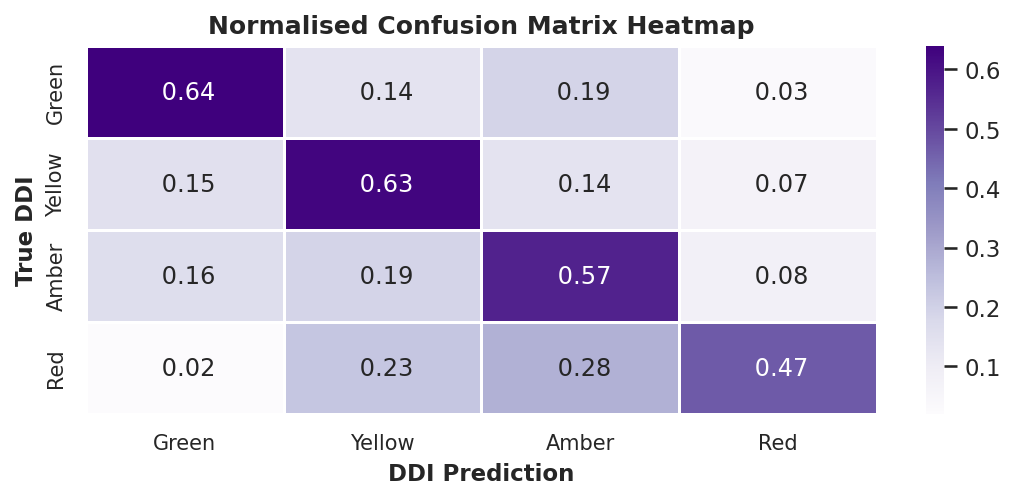

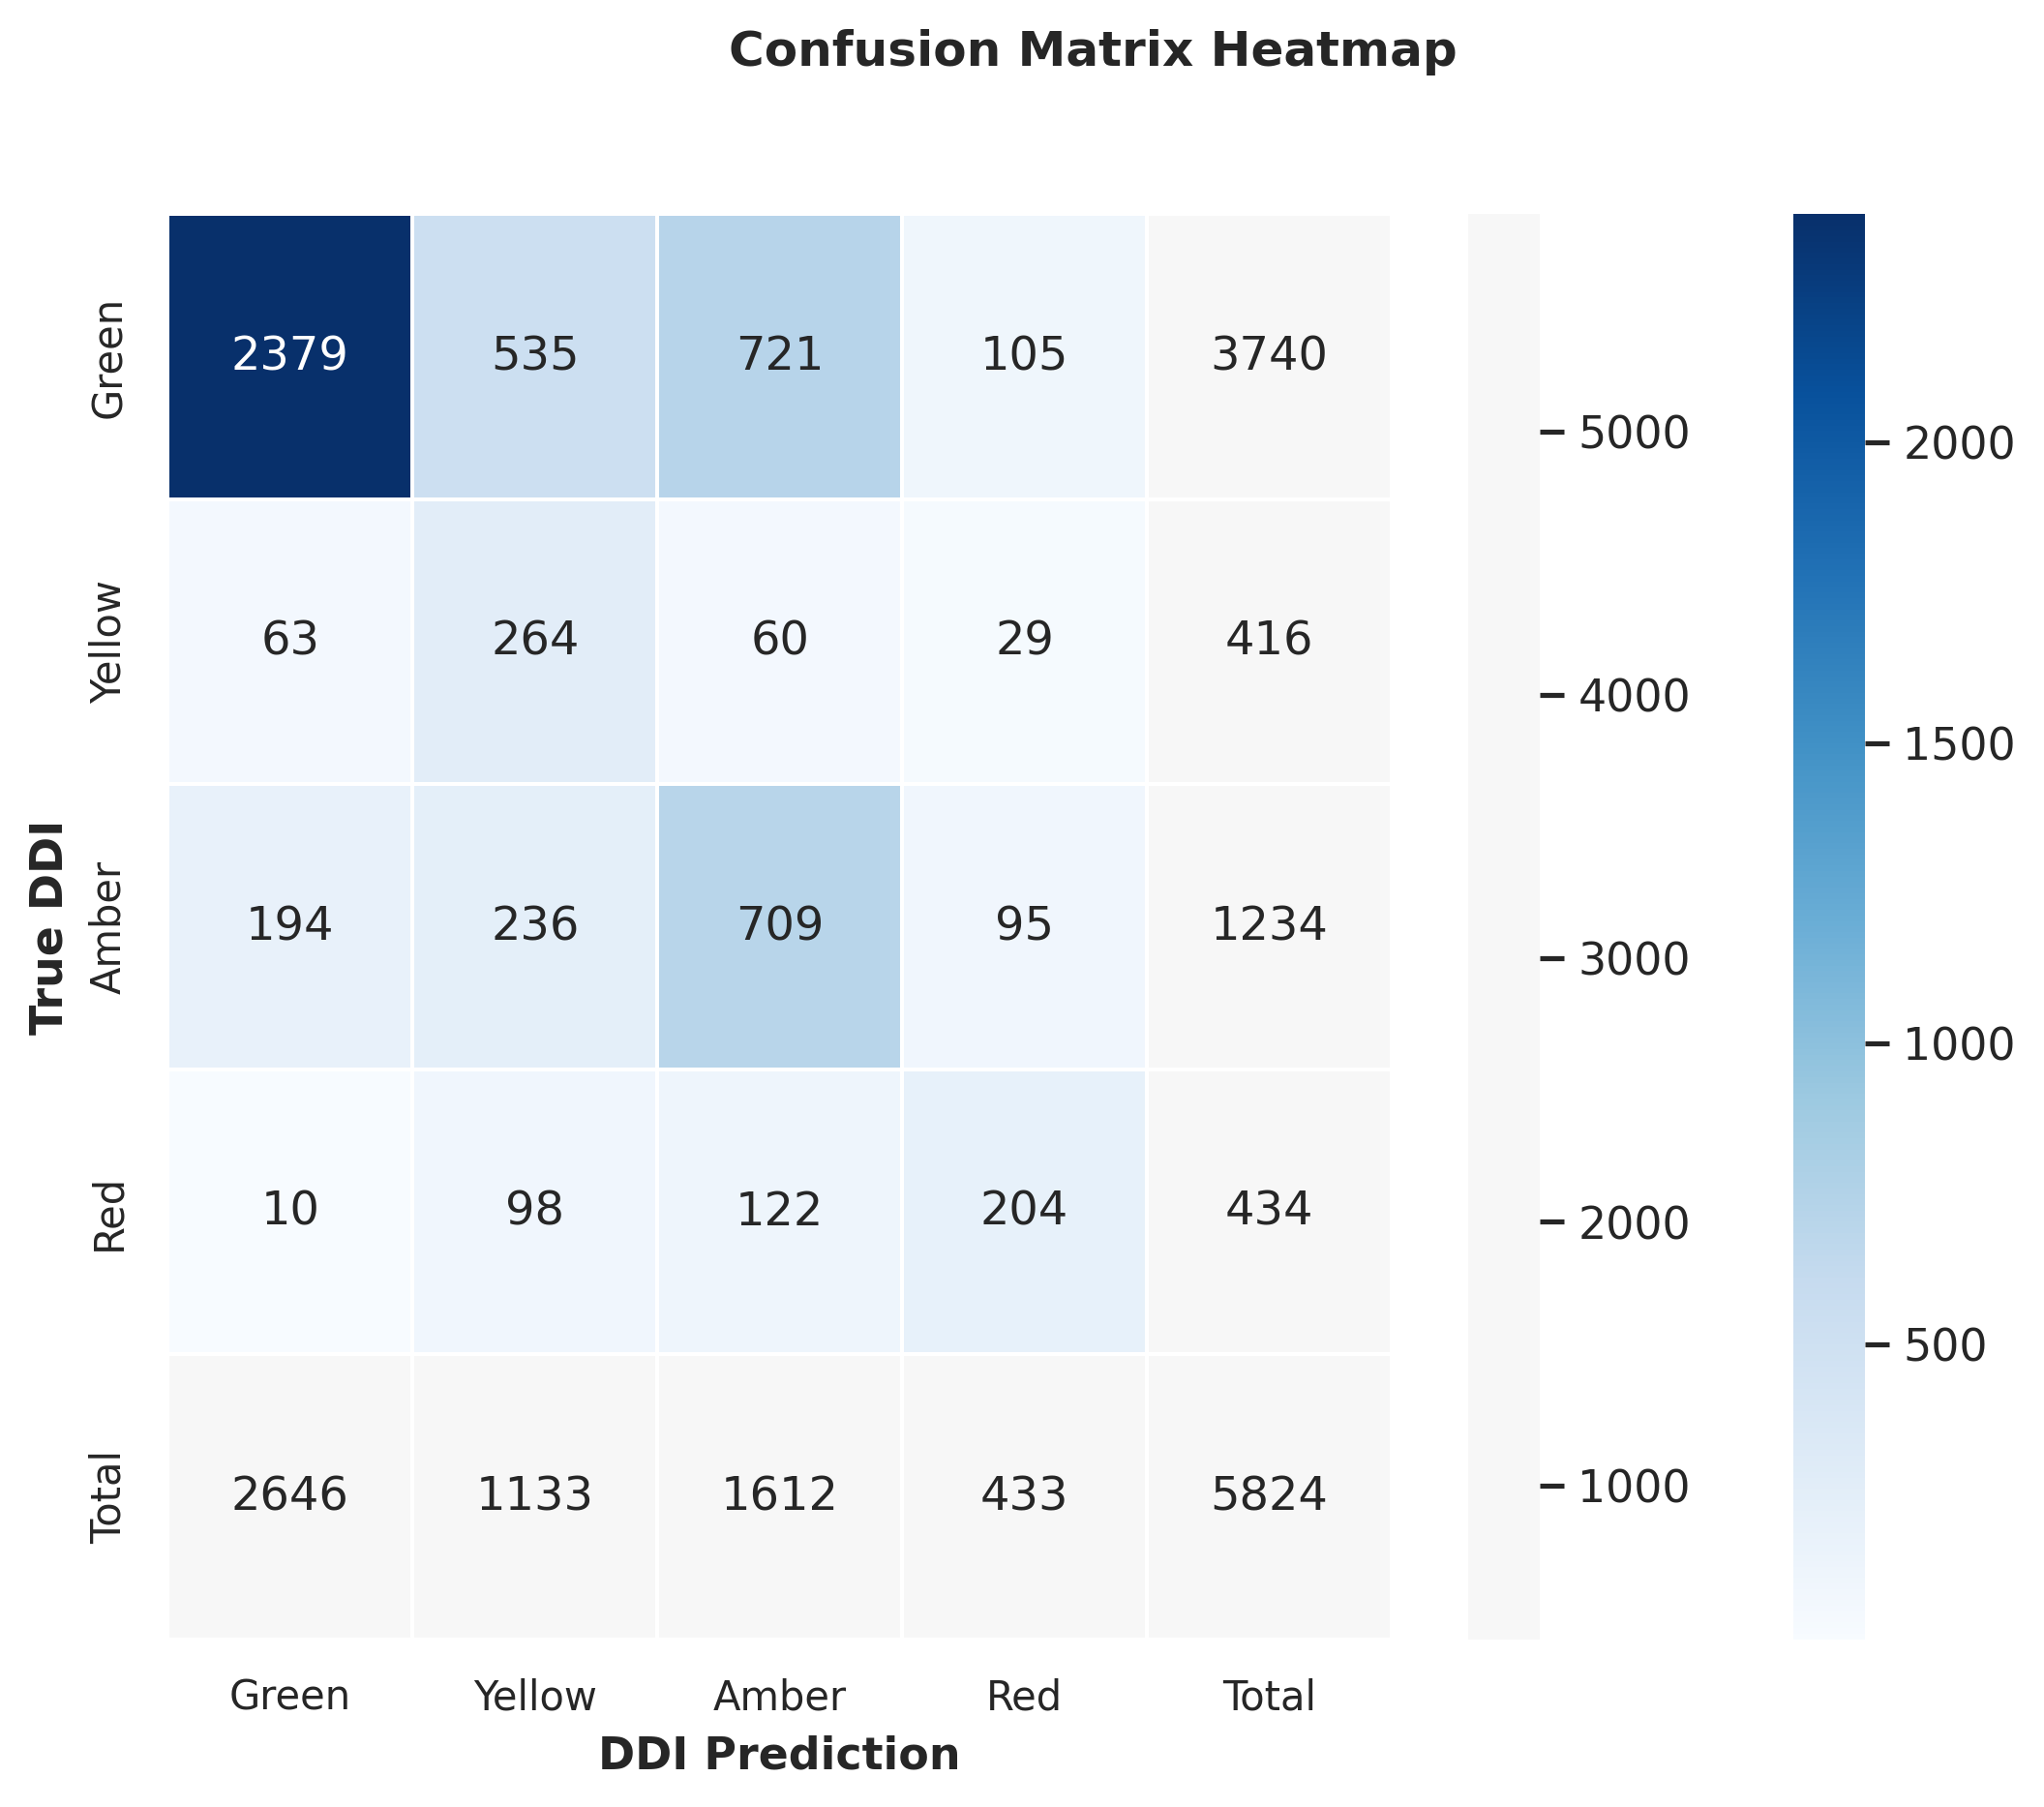

In [ ]:
def DeepARV_evaluation():

  # Load dataset and pretrained models
  ind_test  = load_independent_test_set()
  deepARV_ensemble = DeepARV_ensemble(test_df=ind_test)
  deepARV_ensemble.load_pretrained_models()

  # Test and visualize results from final model
  deepARV_ensemble.test()
  deepARV_ensemble.all_results_df
  deepARV_ensemble.visualize_confusion_matrix()
  return

DeepARV_evaluation()